# A 1-qubit perceptron
My custom perceptron algorithm on a single qubit

In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, BasicAer, Aer
from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_bloch_multivector

In [2]:
def k2vec(k, m=2):
    """
        Parameters: 
            - k (integer) the integer number for the corresponding binary vector
            - m (integer) the length of binary string (needed to distinguish all possibilities)
        Returns: 
            - v (list) a binary vector correspoding to integer k 
        
        Description: By taking a fixed total ordering of binary strings of fixed length we
        can associate each binary vector with an integer. The integer is converted to a 
        binary string which can be used to generate unique vectors.
    """
    
    v = -1*np.ones(m)
    binary_string = ("{:0%db}"%m).format(k) # convert k to an m-digit binary number
    #print(binary_string)
    v = list(map(lambda v, b : v**int(b), v, binary_string)) 
    
    return np.array(v)

def draw_state_vector(circ):
    """
        Input: 
            - circ (qiskit.circuit.quantumcircuit.QuantumCircuit) quantum circuit 
              to be executed
        Description:
            - Runs the quantum circuit and prints the resulting quantum state vector 
              and draws the circuit.
    """
    
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    output_state = result.get_statevector(circ, decimals=3)
    print("state vector after circuit:", output_state)
    print(circ.draw())

## All possible 2 bit boolean vectors with elements {-1, 1}

In [3]:
# generate all 2-bit boolean data
data = np.array([k2vec(i,2) for i in range(4)])
for d in data:
    print(d)

[1. 1.]
[ 1. -1.]
[-1.  1.]
[-1. -1.]


## Create a dictionary with the circuits to encode the inputs and weights

In [4]:
k_circ = {}
vec_circ_dict = {}

In [5]:
# encodes k=0
q = QuantumRegister(1, 'q')
c = ClassicalRegister(1, 'c')
circ = QuantumCircuit(q, c)

i = k2vec(0, 2)

# add to dictionary
k_circ[0] = circ
vec_circ_dict[repr(i)] = circ

In [6]:
# encodes k=1
q = QuantumRegister(1, 'q')
c = ClassicalRegister(1, 'c')
circ = QuantumCircuit(q, c)

i = k2vec(1, 2)
print("i:", i)

#circ.h(q[0]) # uncomment to see that this is the correct circuit
circ.z(q[0])
draw_state_vector(circ)

# add to dictionary
k_circ[1] = circ
vec_circ_dict[repr(i)] = circ

i: [ 1. -1.]
state vector after circuit: [1.+0.j 0.+0.j]
        ┌───┐
q_0: |0>┤ Z ├
        └───┘
 c_0: 0 ═════
             


In [7]:
# encodes k=2
q = QuantumRegister(1, 'q')
c = ClassicalRegister(1, 'c')
circ = QuantumCircuit(q, c)

i = k2vec(2, 2)
print("i:", i)

#circ.h(q[0]) # uncomment to see that this is the correct circuit
circ.z(q[0])
circ.x(q[0])

draw_state_vector(circ)


# add to dictionary
k_circ[2] = circ
vec_circ_dict[repr(i)] = circ

i: [-1.  1.]
state vector after circuit: [0.+0.j 1.+0.j]
        ┌───┐┌───┐
q_0: |0>┤ Z ├┤ X ├
        └───┘└───┘
 c_0: 0 ══════════
                  


In [8]:
# encodes k=3
q = QuantumRegister(1, 'q')
c = ClassicalRegister(1, 'c')
circ = QuantumCircuit(q, c)

i = k2vec(3, 2)
print("i:", i)

#circ.h(q[0]) # uncomment to see that this is the correct circuit
circ.z(q[0])
circ.x(q[0])
circ.z(q[0])

draw_state_vector(circ)

# add to dictionary
k_circ[3] = circ
vec_circ_dict[repr(i)] = circ

i: [-1. -1.]
state vector after circuit: [ 0.+0.j -1.+0.j]
        ┌───┐┌───┐┌───┐
q_0: |0>┤ Z ├┤ X ├┤ Z ├
        └───┘└───┘└───┘
 c_0: 0 ═══════════════
                       


## Taking the inner product
We do this in a similar fashion to part 2. First create a superposition, then encode the inputs and weights, finally rotate the quantum state vector in such a way that the inner product information is contained in the amplitude for the |1> outcome.
<br><br>
One change from the previous classifier is that the ancillary qubit is no longer needed, as the inner product infromation is contained in $\beta$ as defined below, which directly determines the probability of a |1> measurement outcome.

$$\Psi = \alpha |0> + \beta |1>$$


In [9]:
def counts_to_output(counts, threshold=0.5):
    # average the results of the circuit
    if len(counts) == 1:
        avg_counts = int([*counts][0]) # unpacking
    else:
        avg_counts = counts['1']/float(1024)

    # Apply threshold
    if avg_counts >= threshold:
        output = 1
    else:
        output = -1
        
    return output

def one_qubit_classifier(i, w, threshold=0.5, vec_circ_dict=vec_circ_dict, print_circ=False):
    """
        Inputs:
            - i (list) 2-dim classical input vector with elemenents {-1, 1}
            - w (list) 2-dim classical weight vector with elemenents {-1, 1}
            - vec_circ_dict (dictionary) keys are the vectors and the values are the circuits that
              encode those vectors
        Returns:
            - counts (dictionary) the results of running the circuit
    """
    
    q = QuantumRegister(1, 'q')
    c = ClassicalRegister(1, 'c')
    circ = QuantumCircuit(q, c)

    circ.h(q[0])
    # encode i
    circ += vec_circ_dict[repr(i)]
    # encode w
    circ += vec_circ_dict[repr(w)]
    # rotation
    circ.h(q[0])
    circ.x(q[0])
    # measure
    circ.measure(q[0],c[0])
    
    if print_circ==True:
        print(circ)
        
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circ, simulator, shots=1024).result()
    counts = result.get_counts(circ)

    output = counts_to_output(counts, threshold)
    return output

In [10]:
outcomes = np.zeros((4,4))

for m in range(4):
    i = k2vec(m, 2)
    for n in range(4):
        w =  k2vec(n, 2)
        outcomes[m][n]  = one_qubit_classifier(i, w, print_circ=True)

        ┌───┐┌───┐┌───┐┌─┐
q_0: |0>┤ H ├┤ H ├┤ X ├┤M├
        └───┘└───┘└───┘└╥┘
 c_0: 0 ════════════════╩═
                          
        ┌───┐┌───┐┌───┐┌───┐┌─┐
q_0: |0>┤ H ├┤ Z ├┤ H ├┤ X ├┤M├
        └───┘└───┘└───┘└───┘└╥┘
 c_0: 0 ═════════════════════╩═
                               
        ┌───┐┌───┐┌───┐┌───┐┌───┐┌─┐
q_0: |0>┤ H ├┤ Z ├┤ X ├┤ H ├┤ X ├┤M├
        └───┘└───┘└───┘└───┘└───┘└╥┘
 c_0: 0 ══════════════════════════╩═
                                    
        ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌─┐
q_0: |0>┤ H ├┤ Z ├┤ X ├┤ Z ├┤ H ├┤ X ├┤M├
        └───┘└───┘└───┘└───┘└───┘└───┘└╥┘
 c_0: 0 ═══════════════════════════════╩═
                                         
        ┌───┐┌───┐┌───┐┌───┐┌─┐
q_0: |0>┤ H ├┤ Z ├┤ H ├┤ X ├┤M├
        └───┘└───┘└───┘└───┘└╥┘
 c_0: 0 ═════════════════════╩═
                               
        ┌───┐┌───┐┌───┐┌───┐┌───┐┌─┐
q_0: |0>┤ H ├┤ Z ├┤ Z ├┤ H ├┤ X ├┤M├
        └───┘└───┘└───┘└───┘└───┘└╥┘
 c_0: 0 ══════════════════════════╩═
  

[[ 1. -1. -1.  1.]
 [-1.  1.  1. -1.]
 [-1.  1.  1. -1.]
 [ 1. -1. -1.  1.]]


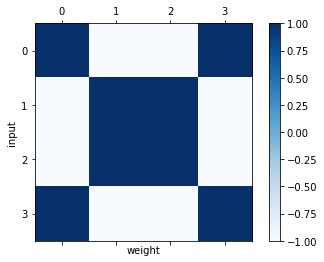

In [11]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.matshow(outcomes, cmap=plt.cm.Blues)
ax.set_xlabel("weight")
ax.set_ylabel("input")

out_plot = ax.imshow(outcomes, cmap='Blues', interpolation='none')
fig.colorbar(out_plot, ax=ax)

#fig.savefig('one-qubit-perceptron.png')

print(outcomes)

I think the one qubit example most clearly illustrates the differences between the classical and quantum perceptron algorithm. We see the ability of quantum hardware to encode $m=2^n$ bits of classical information on m qubits. We also see how this algorithm does not make the distinction between a pattern and it's negative due to the insiginficance of global phase ($\psi = -\psi$). This is an oddity, but may come in handy in learning the infamous boolean XOR data set.

# Learning
## Generate labels
Let's generate data for the Boolean XOR function.

| input | XOR |
| -- | -- |
| 00  | 0 |
| 01 | 1 |
| 10 | 1 |
| 11 | 0 |

I'll consider XOR output of '1' to be a positive label (1) and XOR output of '0' to be a negative label (-1)

In [12]:
XOR_labels = [-1, 1, 1, -1]
print("Data:")
for d in data:
    print(d)

Data:
[1. 1.]
[ 1. -1.]
[-1.  1.]
[-1. -1.]


## Training 

In [13]:
def one_qubit_train(data, labels, vec_circ_dict=vec_circ_dict, 
                    threshold=0.5, lp=0.5, ln=0.5, max_iter=25):
    # Initialize a random w
    w = np.array(random.choices([-1.0,1.0], k=int(math.log(len(labels), 2)))) # k is classical dim

    epochs = 1
    while True:
        m = 0
        for d_idx, d in enumerate(data):
            i = d
            
            # Get output from classification circuit
            output = one_qubit_classifier(i, w)

            # Check for misclassification
            if np.sign(output) != np.sign(labels[d_idx]):
                m += 1
                # case when classified positive (activated) but should be negative
                if np.sign(output) > 0:
                    same_idx = [i for i, z in enumerate(zip(i,w)) if z[0] == z[1]]
                    # randomly select elements to switch signs
                    if len(same_idx) > len(w)*ln:
                        random.shuffle(same_idx)
                        same_idx = same_idx[:int(len(w)*ln)]
                    # change signs of w
                    w[same_idx] *= -1

                # case when classified negative but should be positive
                else:
                    diff_idx = [i for i, z in enumerate(zip(i,w)) if z[0] != z[1]]
                    # randomly select elements to switch signs
                    if len(diff_idx) > len(w)*lp:
                        random.shuffle(diff_idx)
                        diff_idx = diff_idx[:int(len(w)*lp)]
                    # change signs of w
                    w[diff_idx] *= -1
                #print("w:", w)
            
        if m == 0:
            #print("converged in {} epochs".format(epochs))
            #print("w:", w)
            break
        elif epochs == max_iter:
            print("Not converging")
            print("w:", w)
            break
        else:
            epochs += 1
    
    return w

changed the call to one_qubit_classifier() to be integers not vectors. Need to change to a a and make a k2vec_dic

In [14]:
XOR_weight = one_qubit_train(data, XOR_labels)

## Inference

In [15]:
def predict(data, weights, classifier=one_qubit_classifier):
    preds = []
    for d in data:
        # Get the average of the results of running the circuit
        preds.append(one_qubit_classifier(d, weights))

    return preds

In [16]:
predictions = predict(data, XOR_weight)
print(predictions)

[-1, 1, 1, -1]


## Results of running the quantum classifier trained on XOR data set
Plotting our data and coloring the points red if the results of the classifier puts them in the negative class and blue for the positive class.

Text(0.5, 1.0, 'XOR classification')

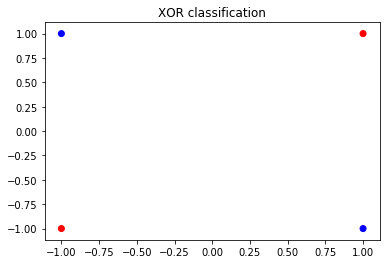

In [17]:
x = data[:, 0]
y = data[:, 1]
colors = ['red' if p==-1 else 'blue' for p in predictions]
fig, _= plt.subplots()
plt.scatter(x, y, c=colors)
plt.title("XOR classification")
#fig.savefig('one-qubit-XOR.png')

## Global phase and the encoding scheme
Our particulary quantum encoding scheme does map one-to-one from classical vectors to quantum state vectors; however, two quantum vectors are considered physically indistinguishable from each other if they only differ by a consant ($|c|^2=1$), called global phase. This actually comes in hany in our classification of the XOR data and leads to two possible weight vectors for the data. 

In [18]:
def sample(data, labels, train=one_qubit_train, n=100):
    d = {} 
    d = defaultdict(lambda:0,d)
    for i in range(n):
        d[repr(train(data, labels))] += 1
    return d

d_XOR =sample(data, XOR_labels)
print(d_XOR)

defaultdict(<function sample.<locals>.<lambda> at 0x7fb5421f7158>, {'array([-1.,  1.])': 37, 'array([ 1., -1.])': 63})


In [19]:
def print_weights(sample_dict, title="", save=False):
    all_strings = ['array([1., 1.])', 'array([ 1., -1.])', 'array([-1.,  1.])', 'array([-1., -1.])']
    key_strings = [k[6:-1] for k in all_strings]
    weight_counts = [0,0,0,0]
    
    for key in sample_dict.keys():
        idx = all_strings.index(key)
        weight_counts[idx] = sample_dict[key]

    fig, _ = plt.subplots()
    plt.bar([0, 1, 2, 3], weight_counts)
    plt.xticks([0, 1, 2, 3], key_strings)
    plt.title(title)
    if save==True:
        fig.savefig(title + '.png')

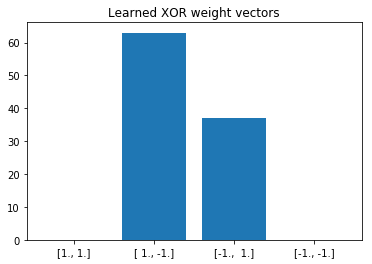

In [20]:
#print_weights(d_XOR, title="Learned XOR weight vectors", save=True)
print_weights(d_XOR, title="Learned XOR weight vectors")

## The limits of a patern classifier
For low dimensional data (e.g. data that can be encoded on 1 or 2 qubits) the classifier acts as if it is picking out a single input and thus the negative of that input to result in positive classification. In other words the perceptron will only be activated when the input is equal to weights (or it's negative). 

| input | output |
| -- | -- |
| 00  | 0 |
| 01 | 0 |
| 10 | 1 |
| 11 | 1 |

Could we learn this data?

Text(0.5, 1.0, 'Horizontal line data')

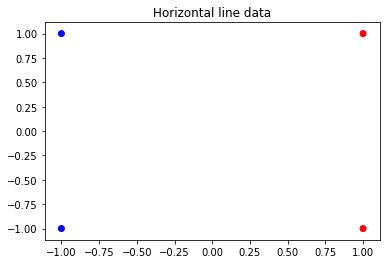

In [21]:
limit_labels = np.array([-1, -1, 1, 1])

x = data[:, 0]
y = data[:, 1]
colors = ['red' if l==-1 else 'blue' for l in limit_labels]
fig, _= plt.subplots()
plt.scatter(x, y, c=colors)
plt.title("Horizontal line data")
#fig.savefig('Horizontal line data.png')

Can we learn this?

In [22]:
limit_weight = one_qubit_train(data, limit_labels)

Not converging
w: [-1. -1.]


The 1-qubit classifier cannot activate for both of the positive labeled inputs (see the figure showing all possible outcomes), thus we cannot learn this function.

## What about boolean AND
Let's generate data for the Boolean AND function.

| input | AND |
| -- | -- |
| 00  | 0 |
| 01 | 0 |
| 10 | 0 |
| 11 | 1 |

I'll consider AND output of '1' to be a positive label (1) and AND output of '0' to be a negative label (-1)

Text(0.5, 1.0, 'AND data')

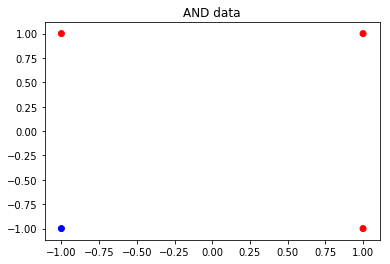

In [23]:
AND_labels = np.array([-1, -1, -1, 1])

x = data[:, 0]
y = data[:, 1]
colors = ['red' if l==-1 else 'blue' for l in AND_labels]
fig, _= plt.subplots()
plt.scatter(x, y, c=colors)
plt.title("AND data")
#fig.savefig('Horizontal line data.png')

What about learning this?

In [24]:
AND_weight = one_qubit_train(data, AND_labels)

Not converging
w: [-1. -1.]


Again. This function does correspond to a possible output of the perceptron. However, below I propose a modified training algorithm that does converge for the boolean AND function, and gives the weight output exactly equal to the postively labeled input (and $\textbf{not the negative}$). 

# A modified training algorithm
Due to global phase, the algorithm cannot learn the AND data set. It cannot classify as an input of [-1,-1] ([1,1]) as positive without also classifying [1,1] ([0,0]) as positive.
<br><br>
Here, I propose the a modification to the training algorithm to learn the "correct" weights, the weights you would expect a classical percpetron to learn.
<br><br>
This algorithm gives the weight vector one would expect in the classical version of the algorithm, and can be used when an input and it's negative have different labels. It can also be used in cases when one does not wants only a specific weight vector, and does not want the negative of a desired weight vector to be returned. 
<br><br>
The algorithm:
- First, for each positively labeled data, find the negative data. 
- If the negative data is not also positively labeled, add it to a list of negative labels
- In the training procedure, if an example is misclassified and does not belong to the list of negative labels, adjust the weights and increment the misclassification counter
- if an example is misclassified and DOES belong to the list of negative labels, adjust the weights BUT do not increment the a misclassification counter
- Repeat until a full iteration through the data produces no increment to the misclassification counter

In [25]:
def find_neg_labels(data, labels):
    pos_data = [data[i] for i,l in enumerate(labels) if l == 1]
    neg_pattern_neg_label = []
    for p in pos_data:
        neg_data = -1*p
        if neg_data in data:
            neg_idx = [i for i, x in enumerate(data) if np.array_equal(x, neg_data)]
            for idx in neg_idx:
                if labels[idx] != 1:
                    neg_pattern_neg_label.append(idx)
                
    #print(pos_data)
    return neg_pattern_neg_label
    
def modified_train(data, labels, neg_labels=[],vec_circ_dict=vec_circ_dict, 
                   threshold=0.5, lp=0.5, ln=0.5, max_iter=25):
    # Initialize a random w
    w = np.array(random.choices([-1.0,1.0], k=int(math.log(len(labels), 2)))) # k is classical dim

    full_loop = False
    epochs = 1
    while True:
        m = 0
        for d_idx, d in enumerate(data):
            i = d
            
            # Get output from classification circuit
            output = one_qubit_classifier(i, w)

            # Check for misclassification
            if np.sign(output) != np.sign(labels[d_idx]):
                if d_idx not in neg_labels:
                    m += 1
                    full_loop = False
                    
                # case when classified positive (activated) but should be negative
                if np.sign(output) > 0:
                    same_idx = [i for i, z in enumerate(zip(i,w)) if z[0] == z[1]]
                    # randomly select elements to switch signs
                    if len(same_idx) > len(w)*ln:
                        random.shuffle(same_idx)
                        same_idx = same_idx[:int(len(w)*ln)]
                    # change signs of w
                    w[same_idx] *= -1

                # case when classified negative but should be positive
                else:
                    diff_idx = [i for i, z in enumerate(zip(i,w)) if z[0] != z[1]]
                    # randomly select elements to switch signs
                    if len(diff_idx) > len(w)*lp:
                        random.shuffle(diff_idx)
                        diff_idx = diff_idx[:int(len(w)*lp)]
                    # change signs of w
                    w[diff_idx] *= -1
                #print("w:", w)
            
        if m == 0:
            if full_loop == False:
                full_loop = True
            else:
                #print("converged in {} epochs".format(epochs))
                #print("w:", w)
                break
        elif epochs == max_iter:
            print("Not converging")
            print("w:", w)
            break
        else:
            epochs += 1
    
    return w

def modified_sample(data, labels, neg_labels, train=modified_train, n=100):
    d = {} 
    d = defaultdict(lambda:0,d)
    for i in range(n):
        d[repr(train(data, labels, neg_labels))] += 1
    return d

In [26]:
# shuffle data
indices = np.arange(len(AND_labels))
np.random.shuffle(indices)

shuffle_data = data[indices]
AND_labels = AND_labels[indices]
print("data", data)
print("labels", AND_labels)

data [[ 1.  1.]
 [ 1. -1.]
 [-1.  1.]
 [-1. -1.]]
labels [-1 -1  1 -1]


In [27]:
neg_labels = find_neg_labels(shuffle_data, AND_labels)
AND_weight = modified_train(shuffle_data, AND_labels, neg_labels)

In [28]:
d_AND = modified_sample(shuffle_data, AND_labels, neg_labels, train=modified_train)

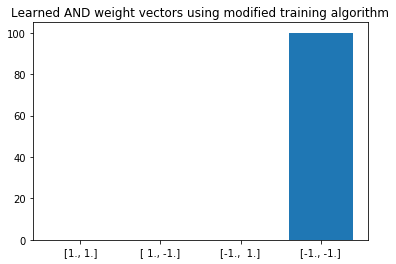

In [29]:
#print_weights(d_AND, title="Learned AND weight vectors using modified training algorithm", save=True)
print_weights(d_AND, title="Learned AND weight vectors using modified training algorithm")

We can see that the modified training algorithm does converge for the boolean AND data set and converges to the weight you would expect the a classical version of the algorithm to do so. However, it should be noted that using this weights for classification in the quantum circuit would cause an activation for inputs that are negative to the weight vector, in this case the [1, 1] vector, which is not true to the boolean AND.
<br><br>
This algorithm may be seen a way to control the outcomes of training when one cares about global phase. Furthermore, if one wanted to use the quantum perceptron algorithm to learn weights, and then used the learned weights for future classificaion in using a classical algorithm, it would give the desired results. Hypothetically, this might occur if there was a speed-up available in using the quantum version of the algorithm for training.    